### Loading Data

- We moved the imports and loading of the dataset and models to the top so they are only loaded once.
- We ensured that the nlp model is loaded only if not already loaded.
- We initialized the sentiment analyzer once.

In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd
import networkx as nx
import spacy
import os
import pickle
from collections import defaultdict
import requests
import spacy.cli
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import re
import matplotlib.dates as mdates
from sklearn.metrics.pairwise import cosine_similarity
from community import community_louvain
import matplotlib.cm as cm
from networkx.algorithms.community.quality import modularity


/Users/thomasschioler/anaconda3/envs/02805SG/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/thomasschioler/anaconda3/envs/02805SG/lib/python3.11/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [2]:
# Load the dataset
data_full_content = pd.read_csv('news_articles_election_candidates_full_content_cleaned.csv')

# Load the spaCy English model
try:
    nlp = spacy.load("en_core_web_trf")
except OSError:
    spacy.cli.download("en_core_web_trf")
    nlp = spacy.load("en_core_web_trf")

# Load manual politician data from JSON file
def load_manual_politicians(file_path="manual_politicians.json"):
    try:
        with open(file_path, "r") as f:
            return json.load(f)
    except FileNotFoundError:
        print(f"File not found: {file_path}. Using an empty dictionary.")
        return {}
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON: {e}")
        return {}

# Load manual politicians
manual_politicians = load_manual_politicians()

# Function to retrieve U.S. politicians and their aliases
def get_current_us_congress_members():
    url = 'https://query.wikidata.org/sparql'
    query = '''
    SELECT DISTINCT ?person ?personLabel ?aliasLabel WHERE {
      VALUES ?position { wd:Q13217683 wd:Q13218630 }  # U.S. Senator and Representative
      ?person p:P39 ?positionStatement.
      ?positionStatement ps:P39 ?position;
                         pq:P580 ?startTime.
      FILTER NOT EXISTS { ?positionStatement pq:P582 ?endTime. }  # Position with no end time
      OPTIONAL { ?person skos:altLabel ?aliasLabel FILTER (LANG(?aliasLabel) = "en") }
      SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
    }
    '''
    headers = {'Accept': 'application/sparql-results+json'}
    response = requests.get(url, params={'query': query}, headers=headers, timeout=60)
    if response.status_code != 200:
        raise Exception(f"SPARQL query failed with status {response.status_code}: {response.text}")
    data = response.json()

    politician_aliases = {}
    for item in data['results']['bindings']:
        canonical_name = item['personLabel']['value']
        alias = item.get('aliasLabel', {}).get('value')
        if canonical_name not in politician_aliases:
            politician_aliases[canonical_name] = set()
            politician_aliases[canonical_name].add(canonical_name)
        if alias:
            politician_aliases[canonical_name].add(alias)
    return politician_aliases

# Fetch U.S. politician aliases
politician_aliases_raw = get_current_us_congress_members()

# Merge with manual politicians
politician_aliases_raw.update(manual_politicians)

# Build alias-to-canonical mapping
alias_to_canonical = {}
for canonical_name, aliases in politician_aliases_raw.items():
    for alias in aliases:
        alias_to_canonical[alias.lower()] = canonical_name

/Users/thomasschioler/anaconda3/envs/02805SG/lib/python3.11/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/Users/thomasschioler/anaconda3/envs/02805SG/lib/python3.11/site-packages/thinc/shims/pytorch.py:253: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by t

In [3]:
# BERT TRANSFORMER MODEL

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

def get_sentiment_score(text):
    if not isinstance(text, str):
        return 3  # Neutral score

    inputs = tokenizer.encode_plus(
        text,
        return_tensors='pt',
        truncation=True,
        max_length=512,
        padding='max_length'
    )

    inputs = {key: val.to(device) for key, val in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1).item()

    sentiment_rating = predicted_class + 1  # Adjust from 0-4 to 1-5

    return sentiment_rating


/Users/thomasschioler/anaconda3/envs/02805SG/lib/python3.11/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/Users/thomasschioler/anaconda3/envs/02805SG/lib/python3.11/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/Users/thomasschioler/anaconda3/envs/02805SG/lib/python3.11/site-packages/transformers/modeling_utils.py:519: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/

### Loading or computing article mentions and politician mentions

- We load the article_mentions and politician_mentions dictionaries from the pickle files you have saved.

In [4]:
# Collect authors' names to exclude them from entities
authors_set = set()
for author in data_full_content['author'].dropna():
    authors = [a.strip() for a in author.split(',')]
    authors_set.update(authors)

# Lowercase authors' names for consistent comparison
authors_set = {author.lower() for author in authors_set}

# Paths to the saved files
article_mentions_file = "article_mentions.pkl"
politician_mentions_file = "politician_mentions.pkl"

# Check if the pickle files exist
if os.path.exists(article_mentions_file) and os.path.exists(politician_mentions_file):
    # Load the saved mentions
    with open(article_mentions_file, "rb") as f:
        article_mentions = pickle.load(f)
    with open(politician_mentions_file, "rb") as f:
        politician_mentions = pickle.load(f)
    print("Loaded article_mentions and politician_mentions from pickle files.")
else:
    # Compute mentions and save them
    print("Computing article_mentions and politician_mentions...")

    # Initialize dictionaries to hold mentions
    article_mentions = defaultdict(set)  # key: article index, value: set of politicians mentioned
    politician_mentions = defaultdict(set)  # key: politician, value: set of article indices where mentioned

    # Build PhraseMatcher to find politician mentions
    from spacy.matcher import PhraseMatcher
    matcher = PhraseMatcher(nlp.vocab, attr='LOWER')

    # Add patterns to the matcher for each politician's aliases
    for politician, aliases in politician_aliases_raw.items():
        patterns = [nlp.make_doc(alias.lower()) for alias in aliases]
        matcher.add(politician, patterns)

    # Process articles
    for idx, content in tqdm(data_full_content['full_content'].items(), desc="Extracting mentions"):
        if not isinstance(content, str):
            continue

        doc = nlp(content)
        matches = matcher(doc)

        mentioned_politicians = set()
        for match_id, start, end in matches:
            politician = nlp.vocab.strings[match_id]
            matched_span = doc[start:end]
            entity_name = matched_span.text.strip()
            entity_name_lower = entity_name.lower()
            # Exclude authors
            if entity_name_lower in authors_set:
                continue
            mentioned_politicians.add(politician)

        if mentioned_politicians:
            article_mentions[idx] = mentioned_politicians
            for politician in mentioned_politicians:
                politician_mentions[politician].add(idx)


    # Save the computed mentions
    with open(article_mentions_file, "wb") as f:
        pickle.dump(article_mentions, f)
    with open(politician_mentions_file, "wb") as f:
        pickle.dump(politician_mentions, f)
    print("Computed and saved article_mentions and politician_mentions.")

Computing article_mentions and politician_mentions...


Extracting mentions: 0it [00:00, ?it/s]/Users/thomasschioler/anaconda3/envs/02805SG/lib/python3.11/site-packages/thinc/shims/pytorch.py:114: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self._mixed_precision):
Extracting mentions: 7556it [59:47,  2.11it/s]

Computed and saved article_mentions and politician_mentions.


### Saving and loading sentiment score

- Before computing sentiment scores, we check if they have already been saved.
- If the scores are saved, we load them and map them back to the DataFrame.
- If not, we compute the sentiment scores, save them to a pickle file, and then map them to the DataFrame.
- This way, sentiment scores are computed only once.

### BERT transformer analysis

- We check if transformer sentiment scores have been saved.
- If so, we load them and map them to the DataFrame.
- If not, we compute them and save them.

In [5]:
# Define the path to save the new sentiment scores
politician_sentiment_scores_file = "politician_sentiment_scores.pkl"

# Check if the sentiment scores are already saved
if os.path.exists(politician_sentiment_scores_file):
    with open(politician_sentiment_scores_file, "rb") as f:
        sentiment_scores = pickle.load(f)
    print("Loaded politician sentiment scores from file.")
else:
    print("Computing politician sentiment scores...")

    # Build PhraseMatcher to find politician mentions
    from spacy.matcher import PhraseMatcher
    matcher = PhraseMatcher(nlp.vocab, attr='LOWER')

    # Add patterns to the matcher for each politician's aliases
    for politician, aliases in politician_aliases_raw.items():
        patterns = [nlp.make_doc(alias.lower()) for alias in aliases]
        matcher.add(politician, patterns)

    sentiment_scores = {}

    # Iterate over articles
    for idx, content in tqdm(data_full_content['full_content'].items(), desc="Computing sentiment scores"):
        if not isinstance(content, str):
            continue

        doc = nlp(content)
        matches = matcher(doc)

        # Dictionary to store contexts for each politician in the article
        politician_contexts = {}

        for match_id, start, end in matches:
            politician = nlp.vocab.strings[match_id]

            # Ensure the politician is actually mentioned in this article
            if politician not in article_mentions.get(idx, set()):
                continue

            if politician not in politician_contexts:
                politician_contexts[politician] = []

            # Extract 20 words before and after the mention
            start_context = max(0, start - 20)
            end_context = min(len(doc), end + 20)
            context_tokens = doc[start_context:end_context]
            context_text = context_tokens.text

            politician_contexts[politician].append(context_text)

        # Compute sentiment scores for each politician in the article
        for politician, contexts in politician_contexts.items():
            combined_context = ' '.join(contexts)
            sentiment_score = get_sentiment_score(combined_context)
            sentiment_scores[(idx, politician)] = sentiment_score

    # Save the sentiment scores
    with open(politician_sentiment_scores_file, "wb") as f:
        pickle.dump(sentiment_scores, f)
    print("Politician sentiment scores computed and saved.")

Computing politician sentiment scores...


Computing sentiment scores: 7556it [2:24:00,  1.14s/it]

Politician sentiment scores computed and saved.


### Saving and loading graph for network 1

- Before creating the graph G, we check if it has already been saved.
- If it exists, we load it using graphml.
- If not, we create the graph as before and save it using graphml.

In [6]:
# Path to save the graph
graph_file = "politician_mention_graph.graphml"

# Check if the graph is already saved
if os.path.exists(graph_file):
    # Load the saved graph
    G = nx.read_graphml(graph_file)
    print("Loaded graph G from file.")
else:
    # Create the network graph
    G = nx.Graph()
    
    # Add nodes with attributes (politicians and articles)
    for politician, articles in politician_mentions.items():
        G.add_node(politician, articles=list(articles))
    
    # Add edges based on co-mentions in articles
    for article_idx, mentioned_politicians in article_mentions.items():
        mentioned_politicians = list(mentioned_politicians)
        for i in range(len(mentioned_politicians)):
            for j in range(i + 1, len(mentioned_politicians)):
                p1, p2 = mentioned_politicians[i], mentioned_politicians[j]
                if G.has_edge(p1, p2):
                    G[p1][p2]['weight'] += 1
                else:
                    G.add_edge(p1, p2, weight=1)
                    
     # Convert list attributes to strings for GraphML compatibility
    for node, data in G.nodes(data=True):
        data['articles'] = ",".join(map(str, data['articles']))
    # Save the graph
    nx.write_graphml(G, graph_file)
    print("Graph G created and saved.")

Graph G created and saved.


In [7]:
# Output graph information
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print("Sample nodes with attributes:")
for node, attrs in list(G.nodes(data=True))[:5]:
    print(f"{node}: {attrs}")
print("Sample edges with weights:")
for u, v, attrs in list(G.edges(data=True))[:5]:
    print(f"{u} - {v}: {attrs}")

Number of nodes: 257
Number of edges: 4013
Sample nodes with attributes:
Donald Trump: {'articles': '0,1,3,4,5,6,7,9,10,12,13,14,15,17,18,19,20,21,22,23,24,25,27,28,29,30,33,34,38,40,42,43,45,48,49,50,51,52,53,55,57,58,64,65,67,69,70,71,74,75,76,77,78,82,83,84,85,86,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,161,162,163,164,165,166,167,168,169,172,173,174,175,176,178,179,180,181,182,183,184,185,187,188,189,191,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,240,241,242,243,246,247,253,254,257,259,260,261,263,265,266,267,269,270,271,272,273,274,275,278,279,280,281,282,284,285,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,30

### Saving and loading bipartite graph 
- Before creating the graph G, we check if it has already been saved.
- If it exists, we load it using graphml.
- If not, we create the graph as before and save it using graphml.

In [8]:
# Path to save the bipartite graph
bipartite_graph_file = "bipartite_graph.graphml"

# Check if the bipartite graph is already saved
if os.path.exists(bipartite_graph_file):
    # Load the saved bipartite graph
    B = nx.read_graphml(bipartite_graph_file)
    print("Loaded bipartite graph B from file.")
else:
    # Create a Bipartite Graph
    B = nx.Graph()

    # Add meta-nodes for media categories
    B.add_node("Democratic Media", bipartite=0, type="Media")
    B.add_node("Republican Media", bipartite=0, type="Media")

    # Initialize dictionaries to track mentions and sentiments
    democratic_mentions = defaultdict(list)
    republican_mentions = defaultdict(list)

    # Define media outlet categories
    democratic_outlets = [
        "cnn", "msnbc", "new york times", "nyt", "npr", "guardian", "huffpost", "huffington post",
        "slate", "vox", "politico", "buzzfeed", "buzzfeed news"
    ]
    republican_outlets = [
        "fox news", "fox", "breitbart", "wall street journal", "wsj", "washington times",
        "national review", "daily caller", "blaze", "newsmax", "federalist", "oann",
        "one america news network"
    ]

    # Function to map source names to media categories
    def get_media_category(source):
        source = str(source).strip().lower()
        # Remove common prefixes and suffixes
        source = re.sub(r'^(the|www\.)\s+', '', source)
        source = re.sub(r'\.com$', '', source)
        source = source.replace('-', ' ')
        source = source.replace('.', ' ')
        source = source.replace(',', '')
        
        # Check for democratic media
        for pattern in democratic_outlets:
            if pattern in source:
                return 'Democratic Media'
        
        # Check for republican media
        for pattern in republican_outlets:
            if pattern in source:
                return 'Republican Media'
        
        return None  # Unknown media category

    # Add a new column for media category
    data_full_content['media_category'] = data_full_content['source'].apply(get_media_category)

    # Process articles
    for idx, row in tqdm(data_full_content.iterrows(), total=data_full_content.shape[0], desc="Building Bipartite Graph"):
        category = row.get('media_category')
        if not category:
            continue

        mentioned_politicians = article_mentions.get(idx, set())

        for politician in mentioned_politicians:
            # Get the sentiment score for this politician in this article
            sentiment = sentiment_scores.get((idx, politician), 3)  # Default to neutral if not found
            if category == "Democratic Media":
                democratic_mentions[politician].append(sentiment)
            elif category == "Republican Media":
                republican_mentions[politician].append(sentiment)


    # Add politician nodes and edges to the bipartite graph
    all_politicians = set(democratic_mentions.keys()).union(republican_mentions.keys())

    for politician in all_politicians:
        # Add politician node
        B.add_node(politician, bipartite=1, type="Politician")

        # Calculate edge attributes for Democratic media
        if politician in democratic_mentions:
            mention_count = len(democratic_mentions[politician])
            avg_sentiment = sum(democratic_mentions[politician]) / mention_count
            B.add_edge("Democratic Media", politician, weight=mention_count, sentiment=avg_sentiment)

        # Calculate edge attributes for Republican media
        if politician in republican_mentions:
            mention_count = len(republican_mentions[politician])
            avg_sentiment = sum(republican_mentions[politician]) / mention_count
            B.add_edge("Republican Media", politician, weight=mention_count, sentiment=avg_sentiment)

    # Save the bipartite graph
    nx.write_graphml(B, bipartite_graph_file)
    print("Bipartite graph B created and saved.")

Building Bipartite Graph: 100%|██████████| 7556/7556 [00:00<00:00, 52459.09it/s]

Bipartite graph B created and saved.


In [9]:
# Output graph information
print(f"Number of nodes: {B.number_of_nodes()}")
print(f"Number of edges: {B.number_of_edges()}")
print("Sample nodes with attributes:")
for node, attrs in list(B.nodes(data=True))[:5]:
    print(f"{node}: {attrs}")
print("Sample edges with weights:")
for u, v, attrs in list(B.edges(data=True))[:5]:
    print(f"{u} - {v}: {attrs}")

Number of nodes: 165
Number of edges: 231
Sample nodes with attributes:
Democratic Media: {'bipartite': 0, 'type': 'Media'}
Republican Media: {'bipartite': 0, 'type': 'Media'}
Lisa Blunt Rochester: {'bipartite': 1, 'type': 'Politician'}
Paul Gosar: {'bipartite': 1, 'type': 'Politician'}
Adam Schiff: {'bipartite': 1, 'type': 'Politician'}
Sample edges with weights:
Democratic Media - Lisa Blunt Rochester: {'weight': 1, 'sentiment': 4.0}
Democratic Media - Paul Gosar: {'weight': 2, 'sentiment': 2.5}
Democratic Media - Adam Schiff: {'weight': 3, 'sentiment': 1.6666666666666667}
Democratic Media - Andrew Cuomo: {'weight': 21, 'sentiment': 1.9047619047619047}
Democratic Media - Amy Coney Barrett: {'weight': 9, 'sentiment': 2.0}


### Sentiment over time

In [10]:
# Ensure 'published_at' column is in datetime format
data_full_content['published_at'] = pd.to_datetime(data_full_content['published_at'], errors='coerce')

# Drop rows with NaT in 'published_at' (optional, depending on your data)
data_full_content = data_full_content.dropna(subset=['published_at'])

# Extract the date from the timestamp
data_full_content['date'] = data_full_content['published_at'].dt.date

## Aggregate Sentiments Over Time
# Compute the average sentiment per day for each politician
# Aggregate Sentiments Over Time
sentiment_over_time_file = 'sentiment_over_time.pkl'

sentiment_over_time = []

for politician, indices in politician_mentions.items():
    indices = list(indices)
    data_list = []

    for idx in indices:
        key = (idx, politician)
        if key in sentiment_scores:
            date = data_full_content.loc[idx, 'date']
            sentiment_score = sentiment_scores[key]
            data_list.append({'date': date, 'sentiment_score': sentiment_score})

    if data_list:
        politician_data = pd.DataFrame(data_list)
        # Group by date and compute average sentiment
        daily_sentiment = (
            politician_data.groupby('date')['sentiment_score']
            .mean()
            .reset_index()
        )
        # Normalize sentiment scores (from 1 to 5, so normalized between 0 and 1)
        daily_sentiment['normalized_sentiment'] = (daily_sentiment['sentiment_score'] - 1) / 4
        daily_sentiment['politician'] = politician
        sentiment_over_time.append(daily_sentiment)

# Combine all politicians' sentiment data into a single DataFrame
if sentiment_over_time:
    sentiment_over_time_df = pd.concat(sentiment_over_time, ignore_index=True)
else:
    sentiment_over_time_df = pd.DataFrame()
    print("No sentiment data available.")

# Save the DataFrame
sentiment_over_time_df.to_pickle(sentiment_over_time_file)
print("Sentiment over time data computed and saved.")

# Display the resulting DataFrame
print(sentiment_over_time_df.head())


Sentiment over time data computed and saved.
         date  sentiment_score  normalized_sentiment    politician
0  2024-10-13         1.809783              0.202446  Donald Trump
1  2024-10-14         2.013393              0.253348  Donald Trump
2  2024-10-15         2.026316              0.256579  Donald Trump
3  2024-10-16         1.957627              0.239407  Donald Trump
4  2024-10-17         1.944664              0.236166  Donald Trump


### Visualize 

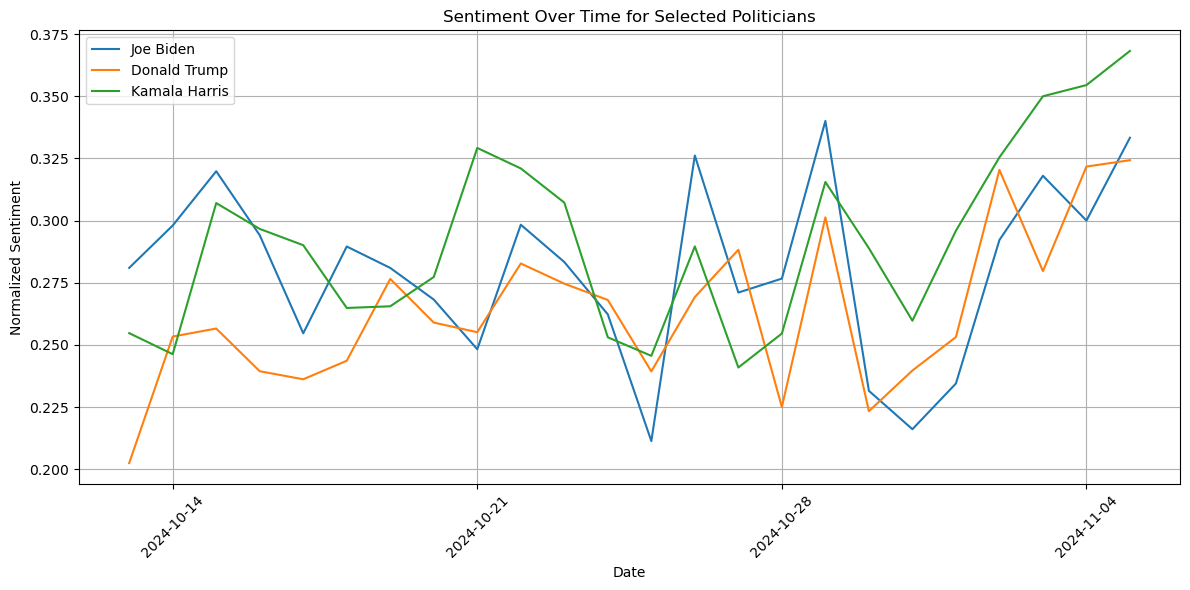

In [11]:
## Visualize Sentiment Trends

# Select top politicians to visualize
top_politicians = ['Joe Biden', 'Donald Trump', 'Kamala Harris']

# Plot sentiment over time for each politician
plt.figure(figsize=(12, 6))

for politician in top_politicians:
    data = sentiment_over_time_df[sentiment_over_time_df['politician'] == politician]
    if not data.empty:
        plt.plot(data['date'], data['normalized_sentiment'], label=politician)
    else:
        print(f"No data available for {politician}")

# Formatting the plot
plt.title('Sentiment Over Time for Selected Politicians')
plt.xlabel('Date')
plt.ylabel('Normalized Sentiment')
plt.legend()
plt.grid(True)

# Improve date formatting
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))  # Every 7 days
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### Key events plotted

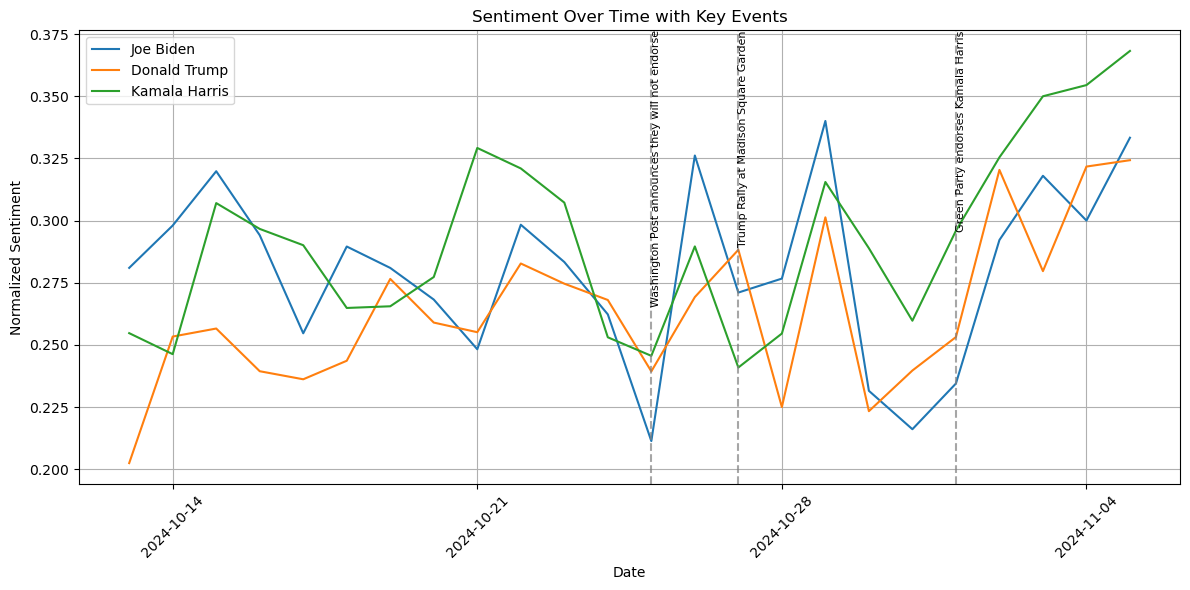

In [12]:
## Identify Key Events and Correlate with Sentiment Changes

# Define key events
# Source: https://en.wikipedia.org/wiki/Timeline_of_the_2024_United_States_presidential_election
key_events = {
    # '2024-09-10': 'ABC presidential debate',
    '2024-10-27': 'Trump Rally at Madison Square Garden',
    # '2024-10-01': 'CBS vice presidential debate',
    '2024-10-25': 'Washington Post announces they will not endorse',
    '2024-11-01': 'Green Party endorses Kamala Harris',
    # Add more events as needed...
}

# Plot sentiment over time with key events
plt.figure(figsize=(12, 6))

for politician in top_politicians:
    data = sentiment_over_time_df[sentiment_over_time_df['politician'] == politician]
    if not data.empty:
        plt.plot(data['date'], data['normalized_sentiment'], label=politician)
    else:
        print(f"No data available for {politician}")

# Add vertical lines for key events
for date_str, event in key_events.items():
    event_date = pd.to_datetime(date_str).date()
    plt.axvline(x=event_date, color='grey', linestyle='--', alpha=0.7)
    plt.text(event_date, plt.ylim()[1], event, rotation=90, verticalalignment='top', fontsize=8)

# Formatting the plot
plt.title('Sentiment Over Time with Key Events')
plt.xlabel('Date')
plt.ylabel('Normalized Sentiment')
plt.legend()
plt.grid(True)

# Improve date formatting
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))  # Every 7 days
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### Community Decetion

#### Sentiment profiles for politicians 

In [13]:
# Initialize sentiment profiles
sentiment_profiles = {}

for politician in all_politicians:
    profile = {}
    # Extract sentiment scores from edges
    if B.has_edge("Democratic Media", politician):
        profile["Democratic Media"] = B["Democratic Media"][politician]["sentiment"]
    else:
        profile["Democratic Media"] = 0  # No connection

    if B.has_edge("Republican Media", politician):
        profile["Republican Media"] = B["Republican Media"][politician]["sentiment"]
    else:
        profile["Republican Media"] = 0  # No connection

    sentiment_profiles[politician] = profile

#### Create similarity based graph

In [14]:
# Convert sentiment profiles to a DataFrame
profiles_df = pd.DataFrame.from_dict(sentiment_profiles, orient="index").fillna(0)

# Compute similarity between sentiment profiles
similarity_matrix = cosine_similarity(profiles_df)

# Create a graph where edge weights are similarity scores
P = nx.Graph()
politicians = profiles_df.index.tolist()

for i, pol1 in enumerate(politicians):
    for j, pol2 in enumerate(politicians):
        if i != j and similarity_matrix[i, j] > 0:  # Ignore self-loops
            P.add_edge(pol1, pol2, weight=similarity_matrix[i, j])

#### Apply community detection

In [15]:
# Detect communities
partition = community_louvain.best_partition(P, weight="weight")

# Group nodes by community
communities = defaultdict(list)
for politician, community_id in partition.items():
    communities[community_id].append(politician)

# Print community results
for community_id, members in communities.items():
    print(f"Community {community_id}: {len(members)} members")
    print(f"Politicians: {members}\n")

Community 0: 85 members
Politicians: ['Lisa Blunt Rochester', 'Paul Gosar', 'Adam Schiff', 'Andrew Cuomo', 'Elizabeth Warren', 'Hakeem Jeffries', 'Michelle Park Steel', 'Deb Haaland', 'Chuck Schumer', 'Lloyd Austin', 'Elena Kagan', 'Merrick Garland', 'Katie Porter', 'Bernie Sanders', 'Ilhan Omar', 'Ron DeSantis', 'Xavier Becerra', 'Don Bacon', 'Anna Paulina Luna', 'Steven Horsford', 'Alexandria Ocasio-Cortez', 'Kevin McCarthy', 'Mike D. Rogers', 'Miguel Cardona', 'Adam Kinzinger', 'Alejandro Mayorkas', 'Antony Blinken', 'Kristi Noem', 'Andy Harris', 'Fred Upton', 'Jamie Raskin', 'Jim Jordan', 'Donald Trump', 'Jamaal Bowman', 'Gavin Newsom', 'Bill de Blasio', 'Mitch McConnell', 'Ryan Zinke', 'Mike Pence', 'Ted Cruz', 'Pete Aguilar', 'Jennifer Granholm', 'Colin Allred', 'Rob Menendez', 'Clarence Thomas', 'Pramila Jayapal', 'Lindsey Graham', 'Josh Hawley', 'John Roberts', 'Pete Sessions', 'Lauren Boebert', 'Young Kim', 'Kyrsten Sinema', 'Sonia Sotomayor', 'Ruben Gallego', 'Marty Walsh', '

#### Analyse and visualize communities 

In [16]:
for community_id, members in communities.items():
    print(f"Community {community_id}:")
    community_profiles = profiles_df.loc[members].mean()
    print(f"Average Sentiment Profile:")
    print(community_profiles)
    print("\n")

Community 0:
Average Sentiment Profile:
Democratic Media    2.527784
Republican Media    1.436312
dtype: float64


Community 1:
Average Sentiment Profile:
Democratic Media    0.172894
Republican Media    2.616683
dtype: float64




/var/folders/tj/czw2xwdj6jv1gvfb9pcj33sh0000gn/T/ipykernel_72100/3125783729.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis", max(partition.values()) + 1)


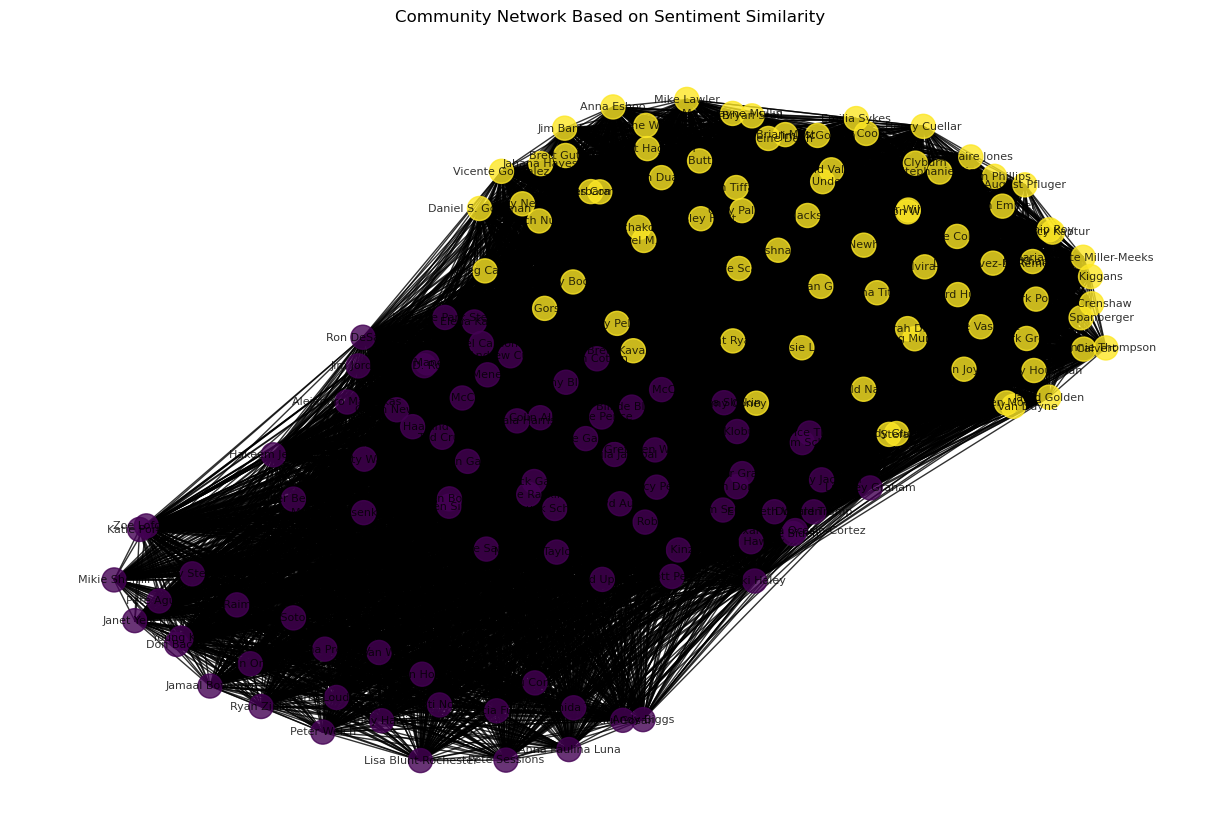

In [17]:
# Assign colors based on community
cmap = cm.get_cmap("viridis", max(partition.values()) + 1)
node_colors = [cmap(partition[node]) for node in P.nodes()]

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(P, seed=42)  # Use a spring layout for visualization
nx.draw(P, pos, with_labels=True, node_color=node_colors, node_size=300, font_size=8, alpha=0.8)
plt.title("Community Network Based on Sentiment Similarity")
plt.show()

#### Compute modularity

In [18]:
# Format communities for modularity calculation
formatted_communities = [members for members in communities.values()]

In [19]:
# Compute modularity score
modularity_score = modularity(P, formatted_communities, weight="weight")

print(f"Modularity Score: {modularity_score}")

Modularity Score: 0.16759325803510364
